#Time Series Prediction

Imports

In [1]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



Loading and Visualizing the data

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Passageiros.csv')
data.head()

,tempo,passageiros
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121


In [3]:
data.shape

(144, 2)

[Text(0.5, 1.0, 'Number of passengers over time')]

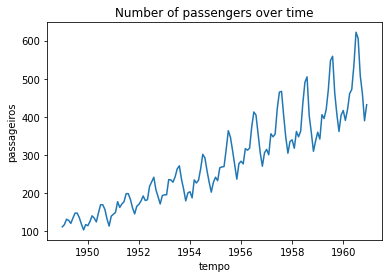

In [4]:
sns.lineplot(x = data.tempo, y = data.passageiros).set(title = 'Number of passengers over time')

Normalizing Data

In [5]:
sc = StandardScaler()
norm_data = sc.fit_transform(data)

In [6]:
x = norm_data[:, 0] 
y = norm_data[:, 1]

[Text(0.5, 1.0, 'Scalonated data')]

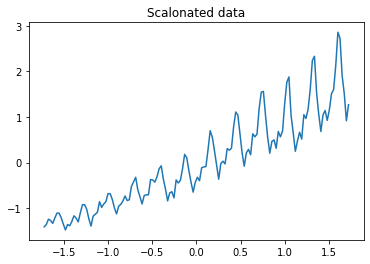

In [7]:
sns.lineplot(x = x, y = y).set(title = 'Scalonated data')

Creating train and test sets

In [8]:
train_size = int(len(data)*0.9)

x_train = x[0:train_size]
y_train = y[0:train_size]
x_test = x[train_size:]
y_test = y[train_size:]

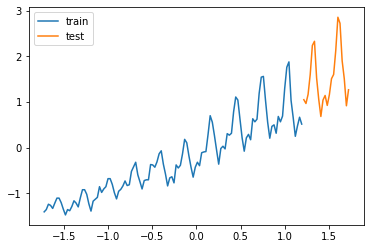

In [9]:
sns.lineplot(x = x_train,y = y_train,label = 'train')
sns.lineplot(x = x_test,y =  y_test, label = 'test')

Creating simple linear model

In [136]:
model = tf.keras.models.Sequential()
model.add(keras.layers.Dense(64, input_dim = 1, activation = 'sigmoid' ))
model.add(keras.layers.Dense(64, activation = 'sigmoid'))
model.add(keras.layers.Dense(1, activation = 'linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 64)                128       
                                                                 
 dense_39 (Dense)            (None, 64)                4160      
                                                                 
 dense_40 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [262]:
callbacks = tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss")
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 500, callbacks=callbacks)


Epoch 1/500
4/4 [==============================] - 0s 56ms/step - loss: 0.1084 - val_loss: 0.3809
Epoch 2/500
4/4 [==============================] - 0s 12ms/step - loss: 0.1068 - val_loss: 0.3828
Epoch 3/500
4/4 [==============================] - 0s 11ms/step - loss: 0.1059 - val_loss: 0.3745
Epoch 4/500
4/4 [==============================] - 0s 12ms/step - loss: 0.1050 - val_loss: 0.3863
Epoch 5/500
4/4 [==============================] - 0s 11ms/step - loss: 0.1040 - val_loss: 0.3973


In [264]:
y_pred = model.predict(x_train)

In [139]:
y_pred.shape

(122, 1)

[Text(0.5, 1.0, 'Fitted line for train data')]

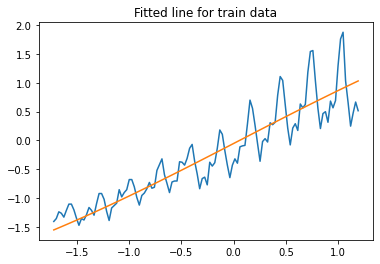

In [265]:
sns.lineplot(x = x_train, y = y_train)
sns.lineplot(x = x_train, y = y_pred[:,0]).set(title = ('Fitted line for train data'))

In [141]:
y_pred_test = model.predict(x_test)

[Text(0.5, 1.0, 'Fitted line for complete data')]

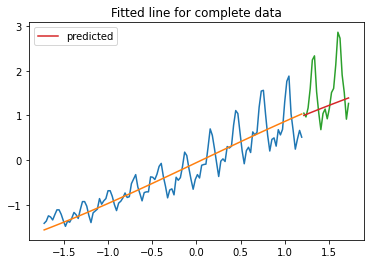

In [266]:
sns.lineplot(x = x_train, y = y_train)
sns.lineplot(x = x_train, y = y_pred[:,0])
sns.lineplot(x = x_test, y = y_test)
sns.lineplot(x = x_test, y = y_pred_test[:,0], label = 'predicted').set(title = ('Fitted line for complete data'))

Reorganizing the data

Idea: Train the network with a modified dataset, passing for the training phase input the number of passengers as well as to the output. The input values must have a series of values that occurred in the past so that the network can predict a future value.


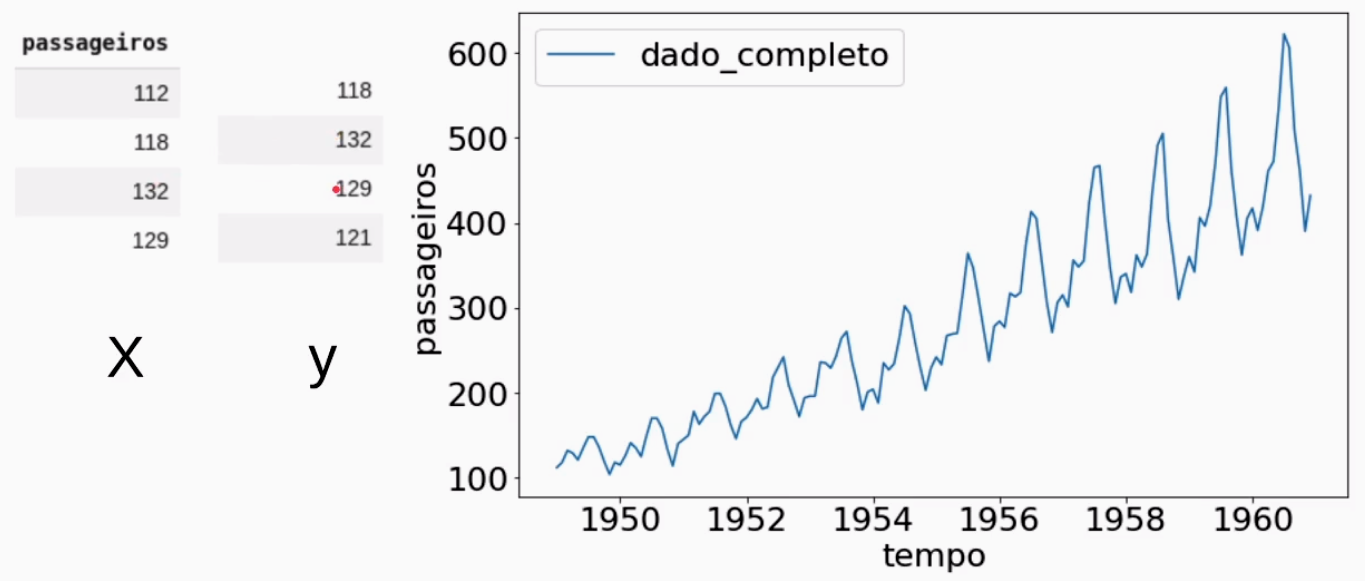

In [166]:
def separate_data(vector, n_steps):
  '''
    Input: vector: number of passengers
           n_steps: number of regressor steps
    
    output: x_new = 2D Array
            y_new = 1D - n_steps
  '''
  x_new, y_new = [], []

  for i in range(n_steps, vector.shape[0]):
    x_new.append(list(vector.loc[i-n_steps:i-1]))
    y_new.append(vector.loc[i])

  x_new, y_new = np.array(x_new), np.array(y_new)

  return x_new,y_new

In [243]:
dim = 3
x_train_new, y_train_new = separate_data(pd.DataFrame(y_train)[0],dim)

In [244]:
x_train_new[:5]

array([[-1.40777884, -1.35759023, -1.24048348],
       [-1.35759023, -1.24048348, -1.26557778],
       [-1.24048348, -1.26557778, -1.33249593],
       [-1.26557778, -1.33249593, -1.21538918],
       [-1.33249593, -1.21538918, -1.10664719]])

In [245]:
y_train_new[:5]

array([-1.26557778, -1.33249593, -1.21538918, -1.10664719, -1.10664719])

In [246]:
x_test_new, y_test_new = separate_data(pd.DataFrame(y_test)[0],dim)

Predicting with new dataset

In [267]:

model2 = tf.keras.models.Sequential()
model2.add(keras.layers.Input(shape = dim))
model2.add(keras.layers.Dense(64, activation = 'relu'))
model2.add(keras.layers.Dense(64, activation = 'relu'))
model2.add(keras.layers.Dense(1, activation = 'linear'))
model2.compile(loss = 'mean_squared_error', optimizer = 'adam')
model2.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 64)                256       
                                                                 
 dense_81 (Dense)            (None, 64)                4160      
                                                                 
 dense_82 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [275]:
history = model2.fit(x_train_new, y_train_new, validation_data = (x_test_new, y_test_new) ,epochs = 500, callbacks = callbacks)


Epoch 1/500
4/4 [==============================] - 0s 25ms/step - loss: 0.0629 - val_loss: 0.2508
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0571 - val_loss: 0.2534
Epoch 3/500
4/4 [==============================] - 0s 15ms/step - loss: 0.0539 - val_loss: 0.2394
Epoch 4/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0533 - val_loss: 0.2384
Epoch 5/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0520 - val_loss: 0.2329
Epoch 6/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0495 - val_loss: 0.2301
Epoch 7/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0489 - val_loss: 0.2358
Epoch 8/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0481 - val_loss: 0.2559


In [271]:
y_pred_new = model2.predict(x_train_new)


In [258]:
x_train.shape

(122,)

[Text(0.5, 1.0, 'Fitted line for train data')]

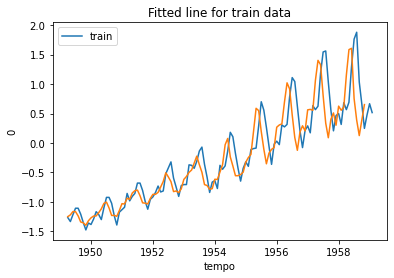

In [272]:

sns.lineplot(x = data.tempo[dim:122], y = y_train_new, label = 'train')
sns.lineplot(x = data.tempo[dim:122], y = pd.DataFrame(y_pred_new)[0]).set(title = ('Fitted line for train data'))

In [273]:
y_test_pred_new = model2.predict(x_test_new)

[Text(0.5, 1.0, 'predicted number of passengers')]

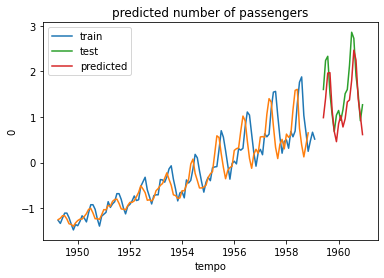

In [274]:
sns.lineplot(x = data.tempo[dim:122], y = y_train_new, label = 'train')
sns.lineplot(x = data.tempo[dim:122], y = pd.DataFrame(y_pred_new)[0])
sns.lineplot(x = data.tempo[122+dim:144], y = y_test_new, label = 'test')
sns.lineplot(x = data.tempo[122+dim:144], y = pd.DataFrame(y_test_pred_new)[0].values, label = 'predicted').set(title = ('predicted number of passengers'))